## WSI 24L
### Ćwiczenie 4 - drzewa decyzyjne z ograniczeniem maksymalnej głębokości drzewa
#### Igor Szabłowski

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Jakość klasyfikatora będzie badana dla zbioru danych [Cardio Vascular Disease Detection](https://www.kaggle.com/datasets/bhadaneeraj/cardio-vascular-disease-detection). Pole cardio informuje o tym czy dana osoba posiada choroby sercowo-naczyniowe.

In [2]:
data = pd.read_csv('cardio_train.csv', delimiter=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,22469,1,155,69.0,130,80,2,2,0,0,1,0
1,989,14648,1,163,71.0,110,70,1,1,0,0,1,1
2,990,21901,1,165,70.0,120,80,1,1,0,0,1,0
3,991,14549,2,165,85.0,120,80,1,1,1,1,1,0
4,992,23393,1,155,62.0,120,80,1,1,0,0,1,0


Część atrybutów w zbiorze nie jest dyskretna (wiek, wzrost, waga, ciśnienie skurczowe, ciśnienie rozkurczowe), więc zostały zdyskretyzowane według widocznych poniżej przedziałów.

In [3]:
discretized_data = pd.DataFrame(index=data.index, columns=data.columns)
data_to_discretize = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
other_data = [column for column in data.columns if column not in data_to_discretize]
discretized_data[other_data] = data[other_data]
discretized_data['age'] = pd.cut(data['age'], bins=[-float('inf'), 15000, 20000, float('inf')], labels=[0, 1, 2])

discretized_data['height'] = pd.cut(data['height'], bins=[-float('inf'), 160, 170, float('inf')], labels=[0, 1, 2])

discretized_data['weight'] = pd.cut(data['weight'], bins=[-float('inf'), 60, 70, float('inf')], labels=[0, 1, 2])

discretized_data['ap_hi'] = pd.cut(data['ap_hi'], bins=[-float('inf'), 120, 140, float('inf')], labels=[0, 1, 2])

discretized_data['ap_lo'] = pd.cut(data['ap_lo'], bins=[-float('inf'), 80, 90, float('inf')], labels=[0, 1, 2])

discretized_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,988,2,1,0,1,1,0,2,2,0,0,1,0
1,989,0,1,1,2,0,0,1,1,0,0,1,1
2,990,2,1,1,1,0,0,1,1,0,0,1,0
3,991,0,2,1,2,0,0,1,1,1,1,1,0
4,992,2,1,0,1,0,0,1,1,0,0,1,0


Dane zostały podzielone na trzy zbiory: trenujący, walidacyjny oraz testowy. Zbiór trenujący i testowy, a następnie trenujący i walidacyjny dzielą się w proporcjach 80/20. Zbiór testowy jest wykorzystywany dopiero w momencie ustalenia się parametrów, do finalnej oceny.

In [4]:
X = discretized_data.drop(columns='cardio')
y = discretized_data['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Zaimplementowane zostały drzewa decyzyjne tworzone algorytmem ID3 z ograniczeniem maksymalnej głębokości drzewa. Parametrami które przyjmuje konstruktory klasy są nazwy kolumn które będą brane pod uwagę podczas tworzenia drzewa, maksymalna głębokość drzewa, oraz bazowa wartość do predykcji.

In [5]:
class ID3:

    def __init__(self, target_columns, max_depth, default_prediction):
        self._default_prediction = default_prediction
        self._target_columns = target_columns
        self._max_depth = max_depth
        self._tree = None

    def get_parameters(self):
        return {'target_columns': self._target_columns, 'max_depth': self._max_depth, 'default_prediction': self._default_prediction}
    
    def _calculate_entropy(self, X):
        proportions = X.value_counts() / len(X)
        entropy = -np.sum(proportions * np.log(proportions))
        return entropy

    
    def _calculate_inf_gain(self, X, y):
        set_entropy = self._calculate_entropy(y)
        weighted_set_entropy = 0
        for value in X.unique():
            subset = y[X == value]
            proportion = len(subset) / len(y)
            entropy = self._calculate_entropy(subset)
            weighted_set_entropy += proportion * entropy
        return set_entropy - weighted_set_entropy
    
    def fit(self, X: pd.DataFrame, y, depth=0):

        if X.isna().any().any():
            X = X.fillna(X.mode().iloc[0])

        if len(y) == 0 or depth == self._max_depth:
            return np.random.choice(y.mode())
        
        if len(y.unique()) == 1:
            return y.iloc[0]

        best_inf_gain = -float('inf')
        
        for column in self._target_columns:
            inf_gain = self._calculate_inf_gain(X[column], y)
            if inf_gain > best_inf_gain:
                best_inf_gain = inf_gain
                best_feature = column
            
        if best_inf_gain == 0:
            return np.random.choice(y.mode())

        tree = {best_feature: {}}

        for value in X[best_feature].unique():
            subset_indexes = X[best_feature] == value
            subset_X = X[subset_indexes]
            subset_y = y[subset_indexes]
            tree[best_feature][value] = self.fit(subset_X, subset_y, depth + 1)

        self._tree = tree
        return tree
    
    def predict(self, X: pd.DataFrame):

        if X.isna().any().any():
            X = X.fillna(X.mode().iloc[0])

        predictions = []
        for _, instance in X.iterrows():
            prediction = self._predict_instance(instance, self._tree)
            predictions.append(prediction)
        return predictions
    
    def _predict_instance(self, instance, tree):
        for feature, subtree in tree.items():
            value = instance[feature]
            if value in subtree:
                if isinstance(subtree[value], dict):
                    return self._predict_instance(instance, subtree[value])
                else:
                    return subtree[value]
        return self._default_prediction

Poniżej przedstawione zostało przykładowe użycie zaimplementowanej klasy. Jako bazowa zwracana wartość została przyjęta najczęściej pojawiająca się wartość ze zbioru wyników dla zbioru trenującego.\
Aby zbudować drzewo należy wywołać metodę `fit` która jako argumenty przyjmuje zbiór trenujący oraz jego wyniki. Instancja klasy trzyma w sobie jako atrybut stworzone drzewo decyzyjne. Następnie na takim obiekcie można wywołać metodę `predict` która jako argument przyjmuje zbiór, a zwraca predykcje do zbioru dobrane przez algorytm.

In [6]:
target_columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
default_prediction = np.bincount(y_train).argmax()

id3 = ID3(target_columns, 10, default_prediction)
id3.fit(X_train, y_train);

predictions = id3.predict(X_validation)

print('Validation data accuracy: ')
print(classification_report(y_validation, predictions))

Validation data accuracy: 
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      5501
           1       0.73      0.66      0.70      5587

    accuracy                           0.71     11088
   macro avg       0.71      0.71      0.71     11088
weighted avg       0.71      0.71      0.71     11088



W celu dobrania optymalnej maksymalnej głębokości, dla dokładności zaimplementowanego klasyfikatora, przeprowadzona została próba dla całkowitych liczb z przedziału [1, 20]. Na wykresie zostały nałożone dokładności dla zbiorów trenującego oraz walidacyjnego. Zbiór trenujący został nałożony w celu pokazania zależoności pomiędzy tymi dwoma zbiorami a maksymalną głębokością drzew. Można zauważyć, że wraz ze wzrostem maksymalnej głębokości wzrasta dokładność wyników dla zbioru treującego, co widać, że nie jest zasadą dla zbioru walidacyjnego który swoje maksimum na danym przedziale posiada dla wartości `max_depth=5`. Po tej wartości dokładność zaczyna spadać dla zbioru walidacyjnego, a dla trenującego dalej rośnie. Dochodzi tutaj do over-fittingu.

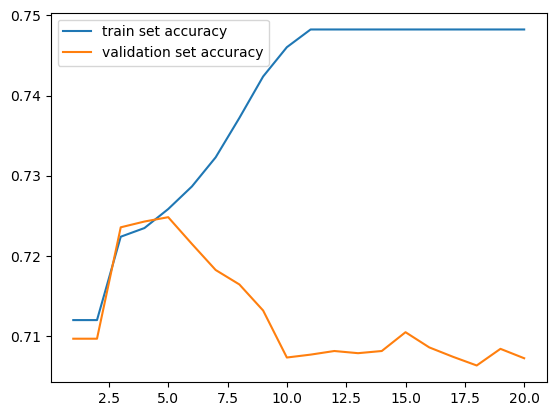

In [7]:
default_prediction = np.bincount(y_train).argmax()
train_accuracy = []
validation_accuracy = []
depths = np.arange(1, 21)

for depth in depths:
    id3 = ID3(target_columns, depth, default_prediction)
    id3.fit(X_train, y_train);
    train_predicts = np.array(id3.predict(X_train))
    validation_predicts = np.array(id3.predict(X_validation))
    train_accuracy.append(np.sum(train_predicts==np.array(y_train))/len(y_train))
    validation_accuracy.append(np.sum(validation_predicts==np.array(y_validation))/len(y_validation))

plt.plot(depths, train_accuracy, depths, validation_accuracy);
plt.legend(['train set accuracy', 'validation set accuracy']);
plt.show()


Implementacja została przetestowana dla optymalnej wartości maksymalnej głębokości `max_depth=5` na zbiorze testującym. Jak można zauważyć wyniki są zadowalające, nie odbiegające znacznie od tego co zostało uzyskane podczas poprzedniej próby. Dokładność w przybliżeniu wynosi $73\%$.

In [8]:
id3 = ID3(target_columns, 5, default_prediction)
id3.fit(X_train, y_train);

predictions = id3.predict(X_test)

print('Test data accuracy: ')
print(classification_report(y_test, predictions))

Test data accuracy: 
              precision    recall  f1-score   support

           0       0.71      0.76      0.74      6948
           1       0.74      0.69      0.72      6913

    accuracy                           0.73     13861
   macro avg       0.73      0.73      0.73     13861
weighted avg       0.73      0.73      0.73     13861



Dla porównania wyników taka sama próba została przeprowadzona dla implementacji klasyfikatora dostępnej w sklearn. W celu zbliżenia ich do siebie jako kryterium została ustawiona entropia. Jak można zauważyć wyniki są bardzo podobne, co może tylko bardziej potwierdzić działanie własnej implementacji klasyfikatora. 

In [9]:
from sklearn.tree import DecisionTreeClassifier

sklearn_id3 = DecisionTreeClassifier(max_depth=5, criterion='entropy')
sklearn_id3.fit(X_train, y_train)

predictions = sklearn_id3.predict(X_test)

print('Sklearn test data accuracy: ')
print(classification_report(y_test, predictions))

Sklearn test data accuracy: 
              precision    recall  f1-score   support

           0       0.72      0.75      0.73      6948
           1       0.74      0.71      0.72      6913

    accuracy                           0.73     13861
   macro avg       0.73      0.73      0.73     13861
weighted avg       0.73      0.73      0.73     13861

